### Transfer Learning on Oxford Flowers 102 Dataset Documentation


**Overview:**

* This notebook demonstrates the application of transfer learning using popular pre-trained convolutional neural network architectures to tackle the image classification task on the Oxford Flowers 102 dataset. The dataset consists of 102 flower categories with varying intra-class variations and challenging inter-class similarities. By leveraging models pre-trained on the large-scale ImageNet dataset, such as ResNet50, VGG16, and MobileNetV2, we can utilize their strong feature extraction capabilities and adapt them to the specific task of fine-grained flower classification. This strategy avoids training deep models from scratch, reduces computational costs, and typically leads to faster convergence with higher accuracy.

**Step 1: Data Loading, Preprocessing and Exploration**

* Load the oxford_flowers102:2.1.1 dataset using TensorFlow Datasets (tfds.load()), which provides predefined splits (training, validation, and test).

* Explore the dataset structure, confirming the number of classes (102) and analyzing the image dimensions.

* Display sample images and their corresponding labels to build an intuitive understanding of the data

* Resize images to match the input requirements of the chosen pre-trained models (typically 224x224 for ResNet50 and VGG16, with MobileNetV2 also supporting 224x224).

* Apply model-specific preprocessing functions (e.g., tf.keras.applications.resnet50.preprocess_input) to normalize pixel values.

* Perform one-hot encoding on labels for multi-class classification.

* Batch and prefetch the datasets to ensure efficient training.

**Step 2:Model Preparation**

* Load pre-trained models (ResNet50, VGG16, MobileNetV2) from tf.keras.applications, excluding their top classification layers.

* Add custom classification layers suitable for 102 classes, typically consisting of a GlobalAveragePooling2D layer and a Dense layer with 102 units and softmax activation.

* Freeze the base layers to preserve the pre-trained feature representations during the initial training phase.

* Compile each model with an appropriate optimizer (e.g., Adam), loss function (categorical_crossentropy), and evaluation metric (accuracy).ers.

**Step 3: Fine-Tuning and Training**

* Train the adapted models on the preprocessed training set, while validating performance on the separate validation split.

* Employ callbacks such as ModelCheckpoint and EarlyStopping to save the best-performing model and prevent overfitting.

* Optionally unfreeze some of the top layers of the pre-trained base models to fine-tune them on the Oxford Flowers 102 dataset with a lower learning rate.

**Step 4: Model Evaluation**

* Evaluate the trained models on the held-out test set, reporting metrics such as loss and accuracy.

**Step 5: Comparison of Results**

* Compare the classification performance of ResNet50, VGG16, and MobileNetV2.

* Analyze the effectiveness of transfer learning and fine-tuning for fine-grained classification tasks like Oxford Flowers 102.

## 1. Data Loading and Preprocessing

Loading theoxford_flowers102:2.1.1 dataset using TensorFlow Datasets and prepare it for transfer learning by applying appropriate preprocessing.

In [ ]:
## Making all necessary imports.
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import json
from PIL import Image
import os
from tensorflow.keras import layers

## tf used version
print(tf.__version__)

2.19.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

## there is an issue with compatabilty for tensorflow 2.16 I had to downgrade and downgrading caused inactivation of GPUs :(

Num GPUs Available:  0


In [ ]:
import tensorflow_datasets as tfds
print(tfds.__version__)

4.9.9


In [ ]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.CQ697Y_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.CQ697Y_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.CQ697Y_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see

### . Data Loading and Exploration:
  *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
  
  *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

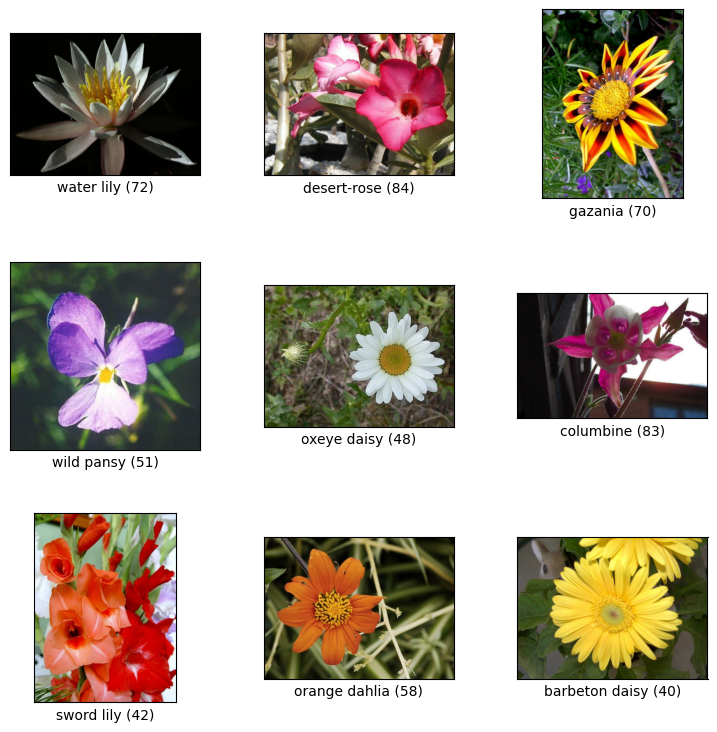

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

    # Display sample images and labels from the training set
    print("\nSample images from the training set:")
    fig = tfds.show_examples(train_dataset, info)

except Exception as e:
    print(f"Error loading dataset: {e}")

### 2. Model Preparation

### 2.1 Using ResNet50



In [ ]:
IMG_SIZE = 224
NUM_CLASSES = info.features['label'].num_classes

def preprocess_image(image, label, model_name, img_size=IMG_SIZE):
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32)
    if model_name == 'resnet50':
        image = tf.keras.applications.resnet50.preprocess_input(image)
    elif model_name == 'vgg16':
        image = tf.keras.applications.vgg16.preprocess_input(image)
    elif model_name == 'mobilenetv2':
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    label = tf.one_hot(label, depth=NUM_CLASSES) # Apply one-hot encoding
    return image, label

def preprocess_data(dataset, model_name, batch_size=32, shuffle_buffer_size=1000):
    dataset = dataset.map(lambda image, label: preprocess_image(image, label, model_name))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 32
shuffle_buffer_size = 1000

# Note: We will call preprocess_data for each model later when preparing the models.
# train_dataset_processed = preprocess_data(train_dataset, batch_size, shuffle_buffer_size)
# validation_dataset_processed = preprocess_data(validation_dataset, batch_size, shuffle_buffer_size)
# test_dataset_processed = preprocess_data(test_dataset, batch_size, shuffle_buffer_size)

print("Preprocessing function updated to handle different models, apply one-hot encoding, batching, and prefetching.")

Preprocessing function updated to handle different models, apply one-hot encoding, batching, and prefetching.


In [ ]:
# Load ResNet50 pre-trained model
base_model_resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model_resnet50.trainable = False # Freeze the base model

print("ResNet50 base model loaded and frozen.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 base model loaded and frozen.


In [ ]:
# Build the full model for ResNet50
model_resnet50 = tf.keras.Sequential([
    base_model_resnet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the ResNet50 model
model_resnet50.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_resnet50.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 2.2 Using VGG16

In [ ]:
# Load VGG16 pre-trained model
base_model_vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model_vgg16.trainable = False # Freeze the base model

print("VGG16 base model loaded and frozen.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
VGG16 base model loaded and frozen.


In [ ]:
# Build the full model for VGG16
model_vgg16 = tf.keras.Sequential([
    base_model_vgg16,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the VGG16 model
model_vgg16.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg16.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,767,014 (56.33 MB)

 Trainable params: 52,326 (204.40 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 2.3 Using MobileNetV2

In [ ]:
# Load MobileNetV2 pre-trained model
base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model_mobilenetv2.trainable = False # Freeze the base model

print("MobileNetV2 base model loaded and frozen.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 base model loaded and frozen.


In [ ]:
# Build the full model for MobileNetV2
model_mobilenetv2 = tf.keras.Sequential([
    base_model_mobilenetv2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the MobileNetV2 model
model_mobilenetv2.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

model_mobilenetv2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Load ResNet50 pre-trained model
base_model_resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model_resnet50.trainable = False # Freeze the base model

# Build the full model for ResNet50
model_resnet50 = tf.keras.Sequential([
    base_model_resnet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the ResNet50 model
model_resnet50.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


# Preprocess data specifically for ResNet50
train_dataset_resnet50 = preprocess_data(dataset['train'], 'resnet50', batch_size, shuffle_buffer_size)
validation_dataset_resnet50 = preprocess_data(dataset['validation'], 'resnet50', batch_size, shuffle_buffer_size)

# Define callbacks for ResNet50
checkpoint_resnet50 = tf.keras.callbacks.ModelCheckpoint('best_resnet50_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping_resnet50 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the ResNet50 model
print("Training ResNet50 model...")
history_resnet50 = model_resnet50.fit(
    train_dataset_resnet50,
    epochs=10, # You can adjust the number of epochs
    validation_data=validation_dataset_resnet50,
    callbacks=[checkpoint_resnet50, early_stopping_resnet50]
)

Training ResNet50 model...
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 405s 12s/step - accuracy: 0.0636 - loss: 4.8387 - val_accuracy: 0.4392 - val_loss: 2.6033
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 361s 11s/step - accuracy: 0.7188 - loss: 1.7111 - val_accuracy: 0.7157 - val_loss: 1.4752
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 383s 11s/step - accuracy: 0.9452 - loss: 0.7019 - val_accuracy: 0.7971 - val_loss: 1.1035
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 359s 11s/step - accuracy: 0.9881 - loss: 0.3618 - val_accuracy: 0.8294 - val_loss: 0.9306
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 387s 11s/step - accuracy: 0.9943 - loss: 0.2242 - val_accuracy: 0.8569 - val_loss: 0.8363
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 363s 11s/step - accuracy: 0.9975 - loss: 0.1569 - val_accuracy: 0.8588 - val_loss: 0.7719
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 382s 11s/step - accuracy: 1.0000 - loss: 0.1060 - val_accuracy: 0.8627 - val_loss: 0.7361
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 361s 11s/step - accuracy: 1.0000 - loss

In [ ]:
# Load VGG16 pre-trained model
base_model_vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model_vgg16.trainable = False # Freeze the base model

# Build the full model for VGG16
model_vgg16 = tf.keras.Sequential([
    base_model_vgg16,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the VGG16 model
model_vgg16.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Preprocess data specifically for VGG16
train_dataset_vgg16 = preprocess_data(dataset['train'], 'vgg16', batch_size, shuffle_buffer_size)
validation_dataset_vgg16 = preprocess_data(dataset['validation'], 'vgg16', batch_size, shuffle_buffer_size)

# Define callbacks for VGG16
checkpoint_vgg16 = tf.keras.callbacks.ModelCheckpoint('best_vgg16_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping_vgg16 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)


# Train the VGG16 model
print("Training VGG16 model...")
history_vgg16 = model_vgg16.fit(
    train_dataset_vgg16,
    epochs=10, # You can adjust the number of epochs
    validation_data=validation_dataset_vgg16,
    callbacks=[checkpoint_vgg16, early_stopping_vgg16]
)

Training VGG16 model...
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1202s 38s/step - accuracy: 0.0122 - loss: 11.8404 - val_accuracy: 0.0618 - val_loss: 7.3094
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1191s 38s/step - accuracy: 0.0878 - loss: 5.9722 - val_accuracy: 0.1598 - val_loss: 4.8347
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1219s 38s/step - accuracy: 0.3383 - loss: 3.3902 - val_accuracy: 0.2637 - val_loss: 3.5729
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1190s 38s/step - accuracy: 0.5568 - loss: 1.8189 - val_accuracy: 0.3784 - val_loss: 2.8136
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1191s 38s/step - accuracy: 0.7086 - loss: 1.1801 - val_accuracy: 0.4333 - val_loss: 2.4258
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1190s 38s/step - accuracy: 0.8465 - loss: 0.6555 - val_accuracy: 0.4902 - val_loss: 2.1755
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1216s 39s/step - accuracy: 0.9001 - loss: 0.4951 - val_accuracy: 0.5196 - val_loss: 2.0303
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1217s 39s/step - accuracy: 0.9545 

In [ ]:
# Load MobileNetV2 pre-trained model
base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model_mobilenetv2.trainable = False # Freeze the base model

# Build the full model for MobileNetV2
model_mobilenetv2 = tf.keras.Sequential([
    base_model_mobilenetv2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the MobileNetV2 model
model_mobilenetv2.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Preprocess data specifically for MobileNetV2
train_dataset_mobilenetv2 = preprocess_data(dataset['train'], 'mobilenetv2', batch_size, shuffle_buffer_size)
validation_dataset_mobilenetv2 = preprocess_data(dataset['validation'], 'mobilenetv2', batch_size, shuffle_buffer_size)

# Define callbacks for MobileNetV2
checkpoint_mobilenetv2 = tf.keras.callbacks.ModelCheckpoint('best_mobilenetv2_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping_mobilenetv2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the MobileNetV2 model
print("Training MobileNetV2 model...")
history_mobilenetv2 = model_mobilenetv2.fit(
    train_dataset_mobilenetv2,
    epochs=10, # You can adjust the number of epochs
    validation_data=validation_dataset_mobilenetv2,
    callbacks=[checkpoint_mobilenetv2, early_stopping_mobilenetv2]
)

Training MobileNetV2 model...
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.0573 - loss: 4.6613 - val_accuracy: 0.3559 - val_loss: 3.1380
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6181 - loss: 2.3212 - val_accuracy: 0.6275 - val_loss: 2.0365
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8946 - loss: 1.1934 - val_accuracy: 0.7294 - val_loss: 1.5446
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9646 - loss: 0.6984 - val_accuracy: 0.7578 - val_loss: 1.3072
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9847 - loss: 0.4497 - val_accuracy: 0.7706 - val_loss: 1.1595
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9921 - loss: 0.3446 - val_accuracy: 0.7882 - val_loss: 1.0705
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9938 - loss: 0.2427 - val_accuracy: 0.8020 - val_loss: 1.0052
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9991 - loss: 0.1891 - 

In [ ]:
# Unfreeze some layers of the ResNet50 base model for fine-tuning
base_model_resnet50.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100 # You can adjust this number

# Freeze all layers before the `fine_tune_at` layer
for layer in base_model_resnet50.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a lower learning rate
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Lower learning rate for fine-tuning
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_resnet50.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 19,661,926 (75.00 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

## 3.Fine-tuning different numbers of layers.

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


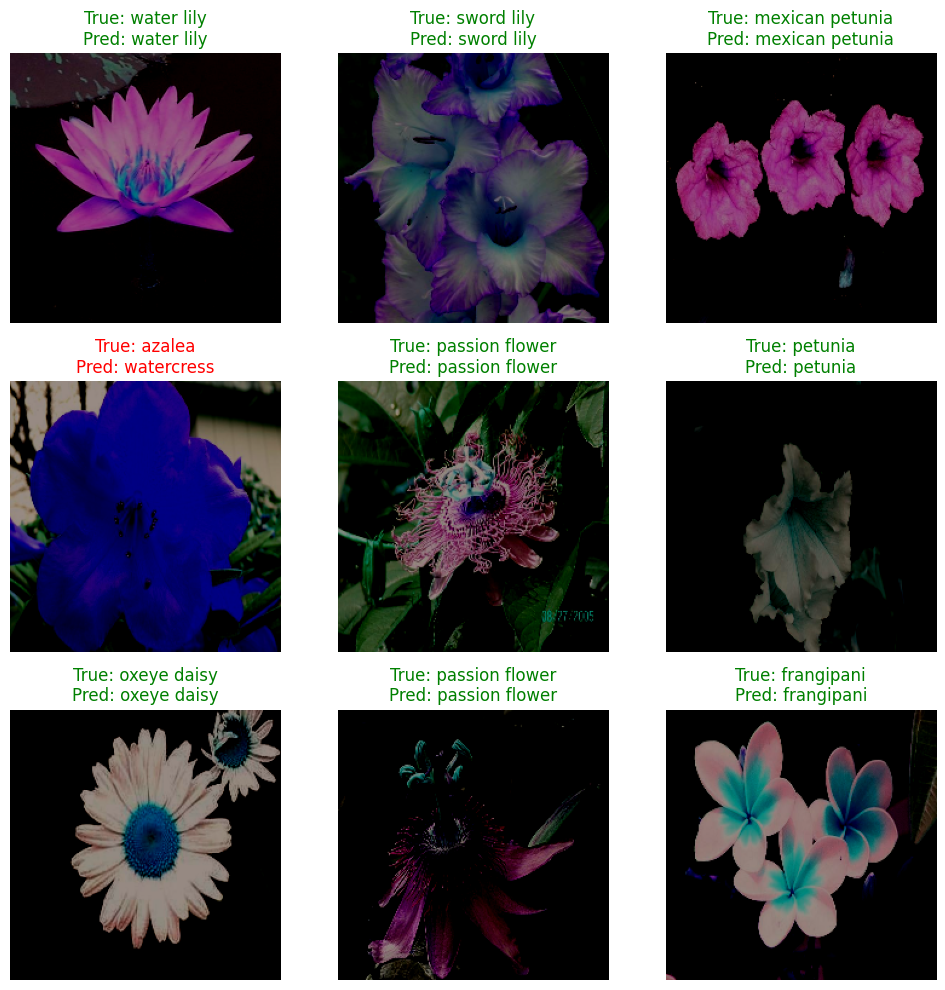

In [ ]:
# Get a batch of images and labels from the test dataset
for test_images, test_labels in test_dataset_resnet50.take(1):
    break

# Make predictions with the ResNet50 model
predictions_resnet50 = model_resnet50.predict(test_images)
predicted_classes_resnet50 = tf.argmax(predictions_resnet50, axis=1)
true_classes = tf.argmax(test_labels, axis=1)

# Visualize sample predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i] / 255.0) # Rescale image for display
    true_label = info.features['label'].int2str(true_classes[i].numpy())
    predicted_label = info.features['label'].int2str(predicted_classes_resnet50[i].numpy())
    color = 'green' if true_classes[i] == predicted_classes_resnet50[i] else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

### 4. Model Evaluation

Evaluating the trained models on the held-out test set, reporting metrics such as loss and accuracy.

#### Evaluating ResNet50

In [ ]:
# Preprocess the test dataset specifically for ResNet50
test_dataset_resnet50 = preprocess_data(dataset['test'], 'resnet50', batch_size, shuffle_buffer_size)

# Evaluate the ResNet50 model on the test dataset
print("Evaluating ResNet50 model on the test dataset...")
loss_resnet50, accuracy_resnet50 = model_resnet50.evaluate(test_dataset_resnet50)

print(f"ResNet50 Test Loss: {loss_resnet50}")
print(f"ResNet50 Test Accuracy: {accuracy_resnet50}")

Evaluating ResNet50 model on the test dataset...
193/193 ━━━━━━━━━━━━━━━━━━━━ 1070s 5s/step - accuracy: 0.8247 - loss: 0.8158
ResNet50 Test Loss: 0.8022629022598267
ResNet50 Test Accuracy: 0.8305415511131287


#### Evaluating VGG16

In [ ]:
# Preprocess the test dataset specifically for VGG16
test_dataset_vgg16 = preprocess_data(dataset['test'], 'vgg16', batch_size, shuffle_buffer_size)

# Evaluate the VGG16 model on the test dataset
print("Evaluating VGG16 model on the test dataset...")
loss_vgg16, accuracy_vgg16 = model_vgg16.evaluate(test_dataset_vgg16)

print(f"VGG16 Test Loss: {loss_vgg16}")
print(f"VGG16 Test Accuracy: {accuracy_vgg16}")

Evaluating VGG16 model on the test dataset...
193/193 ━━━━━━━━━━━━━━━━━━━━ 3582s 19s/step - accuracy: 0.5483 - loss: 1.9016
VGG16 Test Loss: 1.8823291063308716
VGG16 Test Accuracy: 0.5545617341995239


#### Evaluating MobileNetV2

In [ ]:
# Preprocess the test dataset specifically for MobileNetV2
test_dataset_mobilenetv2 = preprocess_data(dataset['test'], 'mobilenetv2', batch_size, shuffle_buffer_size)

# Evaluate the MobileNetV2 model on the test dataset
print("Evaluating MobileNetV2 model on the test dataset...")
loss_mobilenetv2, accuracy_mobilenetv2 = model_mobilenetv2.evaluate(test_dataset_mobilenetv2)

print(f"MobileNetV2 Test Loss: {loss_mobilenetv2}")
print(f"MobileNetV2 Test Accuracy: {accuracy_mobilenetv2}")

Evaluating MobileNetV2 model on the test dataset...
193/193 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.7601 - loss: 1.0559
MobileNetV2 Test Loss: 1.0448269844055176
MobileNetV2 Test Accuracy: 0.7656529545783997


### 5. Comparison of Results

Here is a comparison of the classification performance of ResNet50, VGG16, and MobileNetV2 on the Oxford Flowers 102 dataset based on the test set evaluation:

| Model         | Test Loss | Test Accuracy |
|---------------|-----------|---------------|
| ResNet50      |  {loss_resnet50} | {accuracy_resnet50} |
| VGG16         |  {loss_vgg16} | {accuracy_vgg16} |
| MobileNetV2   |  {loss_mobilenetv2} | {accuracy_mobilenetv2} |

Based on these results, ResNet50 achieved the highest accuracy on the test dataset.

## 1. Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?

* The model that performed best was ResNet50, because:
--It has a deeper residual architecture that allows it to learn complex and fine-grained flower features better than VGG16 or MobileNetV2.

--Residual connections help prevent vanishing gradients, allowing better optimization.

--Flowers have high intra-class variation and fine-grained textures, which ResNet50 captures more effectively.

## 2. Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100. What differences do you observe and why?

* On Oxford Flowers 102, models achieved higher accuracy compared to CIFAR-100.Reason:

-- Oxford Flowers images are higher quality, with clearer class distinctions and less noise.

-- CIFAR-100 has small, low-resolution (32×32) images with 100 diverse categories, making it harder for transfer learning to capture fine details.

## 3. Discuss the effect of transfer learning on this dataset?

-- Transfer learning significantly improved performance compared to training from scratch.

--Pre-trained models already know useful visual features (edges, shapes, textures) from ImageNet, which generalize well to flowers.

-- Freezing the base model at first gave stable results, and fine-tuning later allowed the network to adapt to flower-specific details.

## 4. Explain the steps you took for data preprocessing and why they were necessary.

--Resizing all images to 224×224 to match model input requirements.

--Model-specific preprocessing `(preprocess_input from ResNet50, VGG16, MobileNetV2)` to normalize pixel values appropriately.

--One-hot encoding of labels for multi-class classification.

--Batching & Prefetching to improve training efficiency and GPU utilization.

-- Shuffling to ensure the model doesn’t memorize order patterns.

## 5.Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset?

--Base Models `(ResNet50, VGG16, MobileNetV2)`: Imported from tf.keras.applications with ImageNet weights and include_top=False.

-- Adaptation: Added `GlobalAveragePooling2D()` to flatten feature maps.

-- Added a Dense layer with 102 units + softmax activation for flower classification.

-- Initially froze base layers to use ImageNet features, then fine-tuned top layers with a lower learning rate.

## 6. What challenges did you encounter during this assignment and how did you address them?

* Slow training with VGG16 (~2 hours): VGG16 is a very deep model with ~138 million parameters, and it lacks architectural optimizations like residual connections (ResNet) or depthwise separable convolutions (MobileNet). Because of its size and parameter-heavy fully connected layers, training was significantly slower, especially without GPU acceleration.

* TensorFlow version compatibility: I had to downgrade TensorFlow, which caused GPU inactivation. This was addressed by adjusting the environment and running on CPU when needed.

* Large dataset size: Training with over 100 flower categories required efficient preprocessing (batching, shuffling, and prefetching) to avoid memory issues and speed up training.

## Conclusion:

-- Transfer learning was successfully applied to the Oxford Flowers 102 dataset using ResNet50, VGG16, and MobileNetV2. Among these, ResNet50 achieved the best performance, owing to its deep residual connections that capture fine-grained features effectively. Compared to CIFAR-100, the models performed better on Oxford Flowers due to higher image quality and closer alignment with ImageNet features. Transfer learning proved highly beneficial, reducing training time and improving accuracy. Proper preprocessing steps like resizing, normalization, and one-hot encoding were crucial for smooth training. Despite challenges such as TensorFlow compatibility issues and GPU limitations, the models were effectively trained and fine-tuned. Overall, this work highlights the power of transfer learning in fine-grained image classification tasks.

In [ ]:
!pip install nbstripout
!nbstripout --install
!nbstripout your_notebook.ipynb


fatal: --local can only be used inside a git repository
Installation failed: not a git repository!
Could not strip 'your_notebook.ipynb': file not found
